In [134]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from scipy.integrate import quad, dblquad
from scipy.interpolate import interp1d

# Norms for the PMNS matrix squared:
u_e = [0, 0.674743, 0.302844, 0.0224125]
u_m = [0, 0.0946105, 0.360415, 0.544974]
u_t = [0, 0.230646, 0.33674,  0.432613]


# Effective distance traveled in 1oeV:
l_eff = 4.4434e23 * 5.06773093741 * 1e6

# Importing hypotheses and bin edges
hypotheses = pd.read_csv('hypotheses.csv')
bin_edges = pd.read_csv('bin_edges.csv')

# labeling stuff
hypotheses.columns = ['null', 'alt_1', 'alt_2']
bin_edges.columns = ['energy']
frames = [bin_edges, hypotheses]
ngc_chart = pd.concat(frames, axis=1)

# Importing effective area data:
eff_a = np.loadtxt('effA_-5to30.dat')

# Limits of energy bins in the effective area data:
e_min = 1e-1
e_max = 7.94328e5

# More parameters:
phi0 = 5e-11 * 275270400 # TeV^-1 cm^-2 over 3168 days
e0 = 1 # TeV
index = 3.2 # Taken from NGC paper
width = 0.3 # In log10 scale, for track-like events

# del_m2
del_m2 = 0

base = 10

In [136]:
def TrueIntegrand(e_true, e_reco, del_m2):

    flux = (e_true/e0)**(-index)

    log_gauss = norm.pdf(np.emath.logn(base, e_true), np.emath.logn(base, e_reco), 0.3)
    
    # Finding the appropriate effective energy for the given true energy
    x = eff_a[:,0]
    y = eff_a[:,4]
    f = interp1d(x, y)
    effa = 10000*f(e_true) # cm^2, in data set as m^2

    # Calculating probability that the neutrino will be a muon neutrino (change e_true to eV): 
    osc = (np.cos((del_m2 * l_eff)/(4*e_true*1e12)))**2
    prob_surv = osc * ((u_m[1]*u_m[1]) + (u_m[2]*u_m[2]) + (u_m[3]*u_m[3]))
    prob_emu = osc * ((u_e[1]*u_m[1]) + (u_e[2]*u_m[2]) + (u_e[3]*u_m[3]))
    prob_mu = 0.666666*prob_surv + 0.333333*prob_emu 
   
    jacobian = (e_true*np.log(base))**(-1)
    log_integrand = jacobian*log_gauss*flux*effa*prob_mu

    # print(f"flux: {flux}")
    # print(f"effa: {effa}")
    # print(f"prob_mu: {prob_mu}")
    # print(f"jacobian: {jacobian}")
    # print(f"log_integrand: {log_integrand}")
    
    return log_integrand



def RecoIntegrand(e_reco, del_m2):
    # lower_bound = max(e_min, e_reco-5*np.power(base, 0.3))
    # upper_bound = min(e_max, e_reco+5*np.power(base, 0.3))
    lower_bound = max(e_min, e_reco-5*np.power(10, 0.3))
    upper_bound = min(e_max, e_reco+5*np.power(10, 0.3))
    true_int = quad(TrueIntegrand, lower_bound, upper_bound, args=(e_reco, del_m2), limit=50, epsabs=0.5)
    return 3*phi0*true_int[0]

def RecoInt(e_start, e_end, del_m2):
    return quad(RecoIntegrand, e_start, e_end, args=(del_m2, ), limit=50, epsabs=0.5)[0]

def Integral(e_start, e_end, del_m2):
    int = dblquad(TrueIntegrand, e_start, e_end, lambda y: y-5*np.power(base, 0.3), lambda y: y+5*np.power(base, 0.3), args=(del_m2, ), epsabs=0.5)
    return int[0]



In [131]:
# test = Integral(1, 1.122, 0)
# print(test)
# test1 = RecoInt(1, 1.12, 0)
# print(test1)
# test2 = TrueIntegrand(1000, 1000, 0)
# test3 = RecoIntegrand(1, 0)
print(test2)


effa: 4060750.0
2.0753414651821498e-07


In [138]:
int_approx = []
for i in range(len(ngc_chart['energy']) - 1):
    e_t = ngc_chart['energy'][i]
    e_t_next = ngc_chart['energy'][i+1]
    int_approx.append(RecoIntegrand(e_t, 0)*(e_t_next-e_t))
int_approx.append(0)





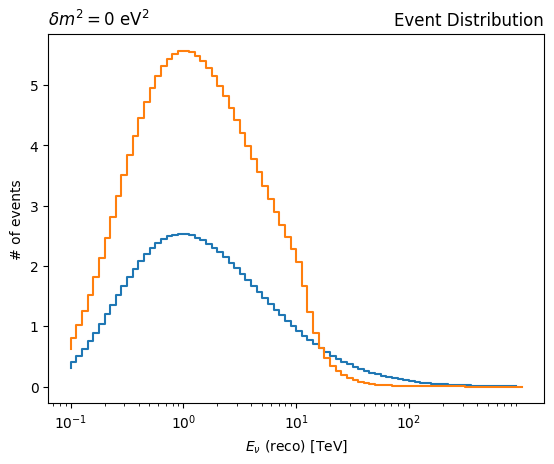

In [139]:
fig, ax = plt.subplots()
null, = ax.step(ngc_chart['energy'], ngc_chart['null'])
hyp_178, = ax.step(ngc_chart['energy'], int_approx)
ax.set_xscale('log')
ax.set_xticks([10**-1, 10**0, 10**1, 10**2])
ax.set_xlabel(r"$E_{\nu}$ (reco) [TeV]")
ax.set_ylabel(r"# of events")
ax.set_title(r"$\delta m^2 = 0$ eV$^2$", loc="left")
ax.set_title(r"Event Distribution", loc="right")
plt.show()